# 卷积网络CNN
## 模型搭建  优化（selu）
## 深度可分离网络 参数量减少  先进行通道数的卷积再进行1*1*N卷积最后叠加
## 参数量  1/卷积个数 + 1/卷积尺寸平方

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [16]:
from sklearn.preprocessing import StandardScaler

print(x_train.astype(np.float32).shape)
print(x_train.astype(np.float32).reshape(-1, 1).shape)
# -1视原矩阵的样本数个数
print(x_train.astype(np.float32).reshape(-1, 1).reshape(-1, 28, 28).shape)
print(x_train.astype(np.float32).reshape(-1, 1).reshape(-1, 28, 28, 1).shape)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28, 1)
print(x_train_scaled.shape)

(55000, 28, 28)
(43120000, 1)
(55000, 28, 28)
(55000, 28, 28, 1)
(55000, 28, 28, 1)


In [17]:
model = keras.Sequential()
# 相比较于relu  采用从activation function：selu的效果会更好但计算时间会更长
# 2层卷积1层池化， filters 输出通道 也对应卷积核个数
# padding 卷积后的尺寸
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
#为了缓解损失，所以filters翻倍
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3,
                              padding='same',
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])
#
# #深度可分离卷积
# model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3,
#                                        padding='same',
#                                        activation='selu'))

In [18]:
model.summary()
# 第二层参数计算 3*3*32*32
# 卷积核尺寸3*3*32 卷积得到28*28*1
# 3*3*32*32  得到28*28*32

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [19]:
model.variables
# <tf.Variable 'conv2d_1/kernel:0' shape=(3, 3, 32, 32)  最后32为输出到对应的神经元

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 32) dtype=float32, numpy=
 array([[[[ 1.34558186e-01, -1.01751968e-01, -5.50142005e-02,
            7.32192993e-02, -1.36830002e-01, -5.87228686e-02,
            1.10812292e-01, -1.15884244e-02,  1.79234892e-02,
           -9.36996192e-02, -4.72286567e-02, -1.00805119e-01,
            3.47048044e-05,  1.48787051e-02,  3.48056555e-02,
           -5.96672073e-02,  9.94983166e-02,  1.26226828e-01,
           -2.95841619e-02, -3.96445319e-02, -1.96441188e-02,
            1.12058684e-01,  1.35946557e-01, -2.21815035e-02,
            4.54816669e-02,  1.21598914e-01, -1.58320367e-02,
            1.86527073e-02, -8.96939039e-02,  9.08919126e-02,
            1.41119108e-01, -5.99820167e-02]],
 
         [[-1.35564998e-01,  8.14302266e-03,  5.05266041e-02,
           -2.56281197e-02, -4.38030139e-02,  2.42682546e-02,
           -1.21788234e-01,  1.39693871e-01, -1.18278719e-01,
            8.80477577e-02,  5.83313406e-03, -2.83738747e-02,
         

In [21]:
logdir = './cnn-relu-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')

callbacks = [keras.callbacks.TensorBoard(logdir),
             keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
             keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]

history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

Epoch 1/10
1719/1719 [==============================] - 15s 5ms/step - loss: 0.7713 - accuracy: 0.7193 - val_loss: 0.4396 - val_accuracy: 0.8446
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4155 - accuracy: 0.8467 - val_loss: 0.3490 - val_accuracy: 0.8688
Epoch 3/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3509 - accuracy: 0.8697 - val_loss: 0.3288 - val_accuracy: 0.8830
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3178 - accuracy: 0.8829 - val_loss: 0.3280 - val_accuracy: 0.8796
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2923 - accuracy: 0.8914 - val_loss: 0.2814 - val_accuracy: 0.8916
Epoch 6/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2727 - accuracy: 0.8994 - val_loss: 0.2779 - val_accuracy: 0.8960
Epoch 7/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2565 - accuracy: 0.9045 - val_loss: 0.2703 - val_accuracy

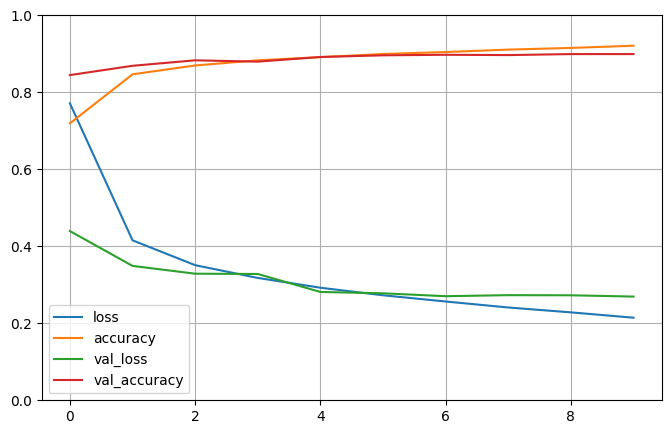

In [22]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

plot_learning_curves(history)

In [23]:
model.evaluate(x_test_scaled,y_test,verbose=0)  # loss metric

[0.29089924693107605, 0.892300009727478]